In [2]:
#Rubber leaf disease detection and classification

In [1]:
!pip install torch torchvision matplotlib scikit-learn tqdm



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix


In [14]:
import shutil
import os

checkpoint_path = "Rubber_Leaf_Dataset/Compressed_Dataset/.ipynb_checkpoints"

if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print("✅ .ipynb_checkpoints removed")
else:
    print("ℹ️ No checkpoint folder found")


✅ .ipynb_checkpoints removed


In [15]:
DATASET_DIR = "Rubber_Leaf_Dataset/Compressed_Dataset/"

In [16]:
classes = os.listdir(DATASET_DIR)
classes


['Anthracnose', 'Dry_Leaf', 'Healthy', 'Leaf_Spot']

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [18]:
full_dataset = datasets.ImageFolder(
    root=DATASET_DIR,
    transform=transform
)

class_names = full_dataset.classes
num_classes = len(class_names)

print(class_names)
print("Total images:", len(full_dataset))


['Anthracnose', 'Dry_Leaf', 'Healthy', 'Leaf_Spot']
Total images: 1741


In [19]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)


In [20]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


C:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\danis/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 53.9MB/s]


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [23]:
EPOCHS = 15

train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:24<00:00,  1.60it/s]


Epoch [1/15] | Train Acc: 75.70% | Val Acc: 91.95%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:19<00:00,  2.02it/s]


Epoch [2/15] | Train Acc: 95.40% | Val Acc: 97.70%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:20<00:00,  1.95it/s]


Epoch [3/15] | Train Acc: 94.50% | Val Acc: 98.47%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:19<00:00,  1.97it/s]


Epoch [4/15] | Train Acc: 97.78% | Val Acc: 98.08%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:17<00:00,  2.25it/s]


Epoch [5/15] | Train Acc: 97.04% | Val Acc: 98.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:17<00:00,  2.26it/s]


Epoch [6/15] | Train Acc: 97.13% | Val Acc: 98.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:16<00:00,  2.37it/s]


Epoch [7/15] | Train Acc: 97.45% | Val Acc: 99.23%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:16<00:00,  2.32it/s]


Epoch [8/15] | Train Acc: 96.39% | Val Acc: 99.62%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.13it/s]


Epoch [9/15] | Train Acc: 98.36% | Val Acc: 99.62%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.11it/s]


Epoch [10/15] | Train Acc: 98.11% | Val Acc: 98.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.07it/s]


Epoch [11/15] | Train Acc: 98.03% | Val Acc: 98.47%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.10it/s]


Epoch [12/15] | Train Acc: 98.11% | Val Acc: 98.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.13it/s]


Epoch [13/15] | Train Acc: 98.69% | Val Acc: 99.23%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.12it/s]


Epoch [14/15] | Train Acc: 98.36% | Val Acc: 98.85%


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:17<00:00,  2.21it/s]


Epoch [15/15] | Train Acc: 98.44% | Val Acc: 99.62%


In [24]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())


In [25]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

 Anthracnose       0.97      0.97      0.97        37
    Dry_Leaf       1.00      1.00      1.00        69
     Healthy       0.99      0.99      0.99        78
   Leaf_Spot       1.00      1.00      1.00        78

    accuracy                           0.99       262
   macro avg       0.99      0.99      0.99       262
weighted avg       0.99      0.99      0.99       262



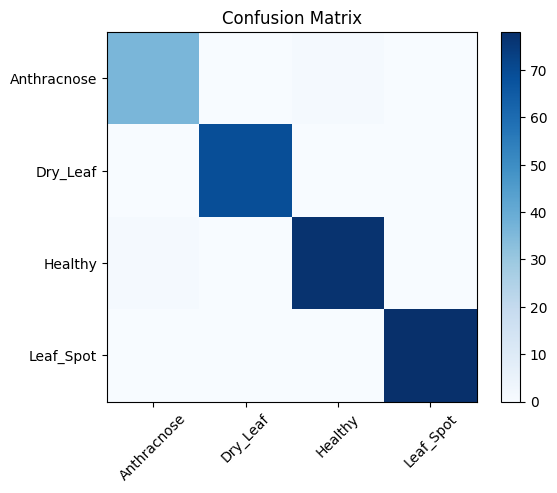

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.title("Confusion Matrix")
plt.show()


In [27]:
torch.save(model.state_dict(), "rubber_leaf_disease_model.pth")
